## Process the SDG Data Items
The purpose of this notebook is to illustrate how to use the SDG Metadata API in conjunction with local CSV files to publish spatial data to ArcGIS Online.  While this example has some elements that are specific to the UNSD workflow it is generic enough to show how to loop and use the API for publishing.  You may to need add or update workflows around publishing to meet your exact needs and working environments.

# install & requirements
Data Package python lib
+ pip install ipdb
+ pip install requests
+ pip install urllib3


# ArcGIS API for Python
Install & Setup Guide here: https://developers.arcgis.com/python/guide/install-and-set-up/#Test-your-install-with-jupyter-notebook 

### Import python libraries

In [3]:
import os, re, json, traceback, sys, copy, urllib
import urllib.request as urlopen
import urllib.request as request
import requests

from arcgis.gis import GIS

import time
from datetime import datetime

# used to prompt for user input
# when using this script internally, you may remove this and simply hard code in your username and password
import getpass

# this helps us do some debugging within the Python Notebook
# another optional component
from IPython.display import display

### Create a connection to your ArcGIS Online Organization
This will rely on using the ArcGIS API for python to connect to your ArcGIS Online Organization to publish and manage data.  For more information about this python library visit the developer resources at [https://developers.arcgis.com/python/](https://developers.arcgis.com/python/)

In [5]:
online_username = input('Username: ')
online_password = getpass.getpass('Password: ')

online_connection = "https://www.arcgis.com"
gis_online_connection = GIS(online_connection, online_username, online_password)

user = gis_online_connection.properties.user.username
print ('Logged in as: ' + user)

data_dir = "FIS4SDGs/csv/"
metadata_dir = "FIS4SDGs/"
failed_series = []

Username: tbutcher_undesa
Password: ········
Logged in as: tbutcher_undesa


### Get the JSON Data from the UN SDG Metadata API

The SDG Metadata API is designed to  retrieve information and metadata on the [Sustainable Development Goals](http://www.un.org/sustainabledevelopment/sustainable-development-goals/).

The Inter-agency Expert Group on SDG Indicators released a series of PDFs that includes metadata for each Indicator. Those PDFs can be downloaded [here](http://unstats.un.org/sdgs/iaeg-sdgs/metadata-compilation/).

The metadata API is an Open Source project maintained by the UN Statisitics division and be be accessed on [github](https://github.com/UNStats-SDGs/sdg-metadata-api)

In [6]:
url = "https://unstats.un.org/SDGAPI/v1/sdg/Goal/List?includechildren=true"
req = request.Request(url)
response = urlopen.urlopen(req)
response_bytes = response.read()
json_data = json.loads(response_bytes.decode("UTF-8"))

# show an example from the metadata
if (json_data):
    print(json_data[0])

{'code': '1', 'title': 'End poverty in all its forms everywhere', 'description': 'Goal 1 calls for an end to poverty in all its manifestations, including extreme poverty, over the next 15 years. All people everywhere, including the poorest and most vulnerable, should enjoy a basic standard of living and social protection benefits.', 'uri': '/v1/sdg/Goal/1', 'targets': [{'goal': None, 'code': '1.1', 'title': 'By 2030, eradicate extreme poverty for all people everywhere, currently measured as people living on less than $1.25 a day', 'description': 'By 2030, eradicate extreme poverty for all people everywhere, currently measured as people living on less than $1.25 a day', 'uri': '/v1/Target/1.1', 'indicators': [{'goal': None, 'target': None, 'code': '1.1.1', 'description': 'Proportion of population below the international poverty line, by sex, age, employment status and geographical location (urban/rural)', 'tier': '1', 'uri': '/v1/Indicator/1.1.1', 'series': [{'goal': None, 'target': Non

### Connect to the Open Data Group

This will be the primary group that the data is shared with to allow sharing with the Open Data Site

<Group title:"SDG Open Data" owner:tbutcher_undesa>
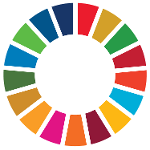

In [7]:
open_data_group_id = '15c1671f5fbc4a00b1a359d51ea6a546'
open_data_group = gis_online_connection.groups.get(open_data_group_id)
display(open_data_group)

### Process the SDG Infomation

Allow the SDG information to be processed either as a batch of by individual series of infomation

In [8]:
process_sdg_information()

NameError: name 'process_sdg_information' is not defined

### processSDGInfomation
This function is where the majority of the work will happen. Here is a basic outline of the steps we will take:
- Build out the item card infomation from the Metadata API and addtional information
- Create an Group in ArcGIS Online for the Goal if needed, otherwise update the property information
- If exists, update and move to Open Data Group
- Publish the CSV File (if the property_update_only flag is False)
- If it doesn't exist, publish as a new Item then move to the Open Data Group

##### goal_code (default None):  Indvidual goal code.  This will process this goal and all the children targets as well
process_sdg_information(goal_code='1')
##### indicator_code (default None):  Individual indicator code.  This will process this indicator and all the children targets as well
process_sdg_information(goal_code='1', indicator_code='1.1')
##### target_code (default None):  Individual Target code.  This will process this target code only
process_sdg_information(goal_code='1', indicator_code='1.1', target_code='1.1.1')
##### series_code (default None):  Individual Series code.  This will process this series code only
process_sdg_information(goal_code='1', indicator_code='1.1', target_code='1.1.1', series_code='SI_POV_DAY1')
##### property_update_only (default False):  If True this will only update the metadata in the item card and will not process the actual data sources
process_sdg_information(goal_code='1', indicator_code='1.1', target_code='1.1.1', series_code='SI_POV_DAY1', property_update_only=True)

In [9]:
def process_sdg_information(goal_code=None, indicator_code=None, target_code=None, series_code=None,
                            property_update_only=False):
    try:
        sdg_metadata = get_metadata()
        for goal in json_data:
            # Determine if we are processing this query Only process a specific series code
            if goal_code is not None and int(goal["code"]) != goal_code:
                continue

            # Get the Thumbnail from the SDG API
            for goal_item in sdg_metadata:
                if goal_item["goal"] == int(goal["code"]):
                    goal_metadata = goal_item
                    break

            if goal_metadata is None:
                continue

            # if a thumbnail was not found use a default thumbnail for icon
            if "icon_url_sq" in goal_metadata:
                thumbnail = goal_metadata["icon_url_sq"]
            else:
                thumbnail = "http://undesa.maps.arcgis.com/sharing/rest/content/items/aaa0678dba0a466e8efef6b9f11775fe/data"

            # Create a Group for the Goal
            group_goal_properties = dict()
            group_goal_properties["title"] = "SDG " + goal["code"]
            group_goal_properties["snippet"] = goal["title"]
            group_goal_properties["description"] = goal["description"]
            group_goal_properties["tags"] = [group_goal_properties["title"]]
            group_goal_properties["thumbnail"] = thumbnail

            # Iterate through each of the targets
            for target in goal["targets"]:
                # Determine if we are processing this query Only process a specific target code
                if target_code is not None and int(target["code"]) != target_code:
                    continue

                group_target_properties = dict()
                group_target_properties["tags"] = ["Target " + target["code"]]
                open_data_group.update(tags=open_data_group["tags"] + group_target_properties["tags"])

                # Iterate through each of the indicators
                for indicator in target["indicators"]:
                    # Allow processing a single indicator
                    if indicator_code and not indicator["code"] == indicator_code:
                        continue

                    process_indicator = dict()
                    process_indicator["name"] = "Indicator " + indicator["code"]  # eg. Indicator 1.1.1
                    process_indicator["tags"] = [process_indicator["name"]]

                    # Append the keyword tags from the metadata as well
                    open_data_group.update(tags=open_data_group["tags"] + process_indicator["tags"])

                    process_indicator["snippet"] = indicator["code"] + ": " + indicator["description"]
                    process_indicator["description"] = "<p><strong>Indicator " + indicator["code"] + ": </strong>" + \
                                                       indicator[
                                                           "description"] + "</p>" + "</p><p><strong>Target " + target[
                                                           "code"] + ": </strong>" + target[
                                                           "description"] + "</p>" + "<p>" + goal[
                                                           "description"] + "</p>"

                    process_indicator["credits"] = "UNSD"
                    process_indicator["thumbnail"] = thumbnail

                    # Iterate through each of the series
                    for series in indicator["series"]:
                        # Determine if we are processing this query Only process a specific series code
                        if indicator_code and not (series["code"] == series_code or series_code is None):
                            continue

                        # Build the metadata properties for the item card
                        item_properties = dict()
                        item_properties["title"] = process_indicator["name"] + " (" + series["code"] + "): " + series[
                            "description"]
                        if not series["description"]:
                            series["description"] = series["code"]
                        snippet = series["code"] + ": " + series["description"]
                        item_properties["snippet"] = (snippet[:250] + "..") if len(snippet) > 250 else snippet
                        item_properties["description"] = "<p><strong>Series " + series["code"] + ": </strong>" + series[
                            "description"] + "</p>" + process_indicator["description"] + \
                                                         "<p><strong>Release Version</strong>: " + series["release"]
                        final_tags = group_goal_properties["tags"] + group_target_properties["tags"] + \
                                     process_indicator["tags"]
                        final_tags.extend(get_series_tags(goal_metadata=goal_metadata, indicator_code=indicator["code"],
                                                          target_code=target["code"], series_code=series["code"]))
                        # Append the version number to the tags
                        final_tags.append(series["release"])
                        item_properties["tags"] = final_tags

                        # Add this item to ArcGIS Online
                        print("Processing series code:", indicator["code"], series["code"])
                        try:
                            if property_update_only:
                                online_item = find_online_item(item_properties["title"])
                                if online_item is None:
                                    failed_series.append(series["code"])
                                else:
                                    # Update the Item Properties from the item_properties
                                    online_item.update(item_properties=item_properties, thumbnail=thumbnail)
                            else:
                                online_item = publish_csv(indicator, series, item_properties=item_properties,
                                                          thumbnail=thumbnail,
                                                          property_update_only=property_update_only)

                            if online_item is not None:
                                display(online_item)
                                # Share this content with the open data group
                                online_item.share(everyone=False, org=True, groups=open_data_group["id"],
                                                  allow_members_to_edit=False)
                                # Update the Group Information with Data from the Indicator and targets
                                #TODO:  Get clean set of tags open_data_group.update(tags=open_data_group["tags"] + [series["code"]])
                            else:
                                failed_series.append(series["code"])
                        except:
                            traceback.print_exc()
                            print("Failed to process series code:", indicator["code"], series["code"])
                            failed_series.append(series["code"])
                            return

    except:
        traceback.print_exc()

### Analyze the CSV file 
Using the ArcGIS REST API `analyze` endpoint, we can prepare the CSV file we are going to use before publishing it to ArcGIS Online. This will help us by returning information about the file inlcuding fields as well as sample records. This step will also lead into future steps in the publishing process.

More info about the analyze endpoint can be found [here](https://developers.arcgis.com/rest/users-groups-and-items/analyze.htm).

In [10]:
def analyze_csv(item_id):
    try:
        sharing_url = gis_online_connection.content.gis.url + "/sharing/rest/content/features/analyze"
        analyze_params = {'f': 'json', 'token': gis_online_connection.con.token,
                          'sourceLocale': 'en-us',
                          'filetype': 'csv', 'itemid': item_id}
        r = requests.post(sharing_url, data=analyze_params)
        analyze_json_data = json.loads(r.content.decode("UTF-8"))
        for field in analyze_json_data["publishParameters"]["layerInfo"]["fields"]:
            field["alias"] = set_field_alias(field["name"])

            # Indicator is coming in as a date Field make the correct
            if field["name"] == "indicator":
                field["type"] = "esriFieldTypeString"
                field["sqlType"] = "sqlTypeNVarchar"

        # set up some of the layer information for display
        analyze_json_data["publishParameters"]["layerInfo"]["displayField"] = "geoAreaName"
        return analyze_json_data["publishParameters"]
    except:
        print("Unexpected error:", sys.exc_info()[0])
        return None



### Publish the CSV file
This function is where the majority of the work will happen. Here is a basic outline of the steps we will take:
- Check to see if a CSV file exists for this series of data
- Determine if this CSV has already been published
- If the CSV has already been published the script will:
  - Update the item properties in case they have changed
  - Move to Open Data Folder under the owner content
- If the CSV has not already been published the script will:
  - Add the file to ArcGIS Online
  - Run the analyze tool to get the publish properties
  - Publish the CSV file to ArcGIS Online
- Move to the Open Data Folder

In [11]:
def publish_csv(indicator, series, item_properties, thumbnail, property_update_only=False):
    # Do we need to publish the hosted feature service for this layer
    try:
        series_title = series["code"] + "_" + indicator["code"].replace(".","") + "_" + online_username + "_" + series["release"].replace('.', '')
        file = os.path.join(data_dir, series["code"] + "_cube.pivot.csv")
        if os.path.isfile(file):
            csv_item_properties = copy.deepcopy(item_properties)
            csv_item_properties["title"] = series_title
            csv_item_properties["type"] = "CSV"
            csv_item_properties["url"] = ""

            # Does this CSV already exist
            csv_item = find_online_item(csv_item_properties["title"])
            if csv_item is None:
                print('Adding CSV File to ArcGIS Online....')
                csv_item = gis_online_connection.content.add(item_properties=csv_item_properties, thumbnail=thumbnail,
                                                             data=file)
                if csv_item is None:
                    return None

                # publish the layer if it was not found
                print('Analyze Feature Service....')
                publish_parameters = analyze_csv(csv_item["id"])
                if publish_parameters is None:
                    return None
                else:
                    publish_parameters["name"] = csv_item_properties["title"]
                    publish_parameters["layerInfo"]["name"] = csv_item_properties["snippet"]

                    print('Publishing Feature Service....')
                    csv_lyr = csv_item.publish(publish_parameters=publish_parameters, overwrite=True)
            else:
                # Update the Data file for the CSV File
                csv_item.update(item_properties=csv_item_properties, thumbnail=thumbnail, data=file)
                # Find the Feature Service and update the properties
                csv_lyr = find_online_item(item_properties["title"])

            # Move to the Open Data Folder
            if csv_item["ownerFolder"] is None:
                print('Moving CSV to Open Data Folder')
                csv_item.move("Open Data")

            if csv_lyr is not None:
                print('Updating Feature Service metadata....')
                csv_lyr.update(item_properties=item_properties, thumbnail=thumbnail)

                if csv_lyr["ownerFolder"] is None:
                    print('Moving Feature Service to Open Data Folder')
                    csv_lyr.move("Open Data")

                return csv_lyr
            else:
                return None
        else:
            return None
    except:
        print("Unexpected error:", sys.exc_info()[0])
        return None

### Find the Online Item
General function to find a given item in ArcGIS Online by the Owner and by the Title

In [12]:
def find_online_item(title):
    try:
        # Search for this ArcGIS Online Item
        query_string = "title:'{}' AND owner:{}".format(title, online_username)
        print('Searching for ' + title)
        search_results = gis_online_connection.content.search(query_string)

        if search_results:
            for search_result in search_results:
                if search_result["title"] == title:
                    diplay(search_result)
                    return search_result
                

        return None
    except:
        print("Unexpected error:", sys.exc_info()[0])
        return None

### Collect SDG Metadata
The Metadata json is located within the data folder and downloaded with the code

In [14]:
def get_metadata():
    try:
        metadata_json_data = json.loads(metadata_dir + "/metadataAPI.json")
        return metadata_json_data
    except:
        return None

### Collect SDG Series Metadata
Information such as standard Tags can also be retrieved from the SDG Metadata API

In [15]:
def get_series_tags(goal_metadata=None, indicator_code=None, target_code=None, series_code=None):
    try:
        for target in goal_metadata["targets"]:
            if target["target"] == target_code:
                for indicator in target["indicators"]:
                    if indicator["indicator"] == indicator_code:
                        for series in indicator["series"]:
                            if series["series"] == series_code:
                                return series["tags"]
        return []
    except:
        traceback.print_exc()
        return []

### Get Field Aliases
Translate the field names and apply a more friendly user name for the alias

In [16]:
def set_field_alias(field_name):
    if field_name == "series_release":
        return "Series Release"
    if field_name == "series_code":
        return "Series Code"
    if field_name == "series_description":
        return "Series Description"
    if field_name == "geoAreaCode":
        return "Geographic Area Code"
    if field_name == "geoAreaName":
        return "Geographic Area Name"
    if field_name == "Freq":
        return "Frequency"
    if field_name == "latest_year":
        return "Latest Year"
    if field_name == "latest_value":
        return "Latest Value"
    if field_name == "latest_source":
        return "Latest Source"
    if field_name == "latest_nature":
        return "Latest Nature"
    if field_name == "last_5_years_mean":
        return "Mean of the Last 5 Years"
    if field_name == "ISO3CD":
        return "ISO3 Code"
    else:
        return field_name.capitalize().replace("_", " ")

### Create a Group for each SDG Goal  (Deprecated)
You can create a Group within your ArcGIS Online Organization for each SDG. As you publish Items, you can share them to the relevant Group(s). This function will create the Group, query the SDG Metadata API to return the Title, Summary, Description, Tags, and Thumbnail for that particular SDG.

In [17]:
def create_group(group_info):
    try:
        # Add the Service Definition to the Enterprise site
        item_properties = dict({
            "title": group_info["title"],
            "snippet": group_info["snippet"],
            "description": group_info["description"],
            "tags": ", ".join([group_info["title"], "Open Data", "Hub"]),
            "thumbnail": group_info["thumbnail"],
            "isOpenData": True,
            "access": "public",
            "isInvitationOnly": True,
            "protected": True
        })

        # Check if there is a group here
        query_string = "title:'{}' AND owner:{}".format(group_info["title"], online_username)
        search_results = gis_online_connection.groups.search(query_string)
        if not search_results:
            # Update the group information
            group = gis_online_connection.groups.create_from_dict(item_properties)
            display(group)
            return group
        else:
            for search_result in search_results:
                if search_result["title"] == group_info["title"]:
                    group_found = True
                    search_result.update(title=group_info["title"], tags=group_info["tags"],
                                         description=group_info["description"],
                                         snippet=group_info["snippet"], access="Public",
                                         thumbnail=group_info["thumbnail"])
                    return search_result
            # the group was not in the returned search results so create now
            group = gis_online_connection.groups.create_from_dict(item_properties)
            display(group)
            return  group
    except:
        traceback.print_exc()

### Clean out the open data site
This step would generally only be used during testing and does not need to be called each time

In [18]:
def cleanup_site():
    user = gis_online_connection.users.get(user)
    user_items = user.items(folder='Open Data', max_items=800)
    for item in user_items:
        print('deleting item ' + item.title)
        item.delete()

    return